<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Dirty Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [1]:
import os
import sys
import pandas as pd
import networkx
from networkx import (
    draw,
    DiGraph,
    Graph,
)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs
from pyjedai.evaluation import Evaluation
from pyjedai.datamodel import Data

d1 = pd.read_csv("./data/der/cora/cora.csv", sep='|')
gt = pd.read_csv("./data/der/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

### Block Building

In [2]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
    ExtendedQGramsBlocking
)

C:\Users\nikol\Desktop\GitHub\pyJedAI-Dev\pyjedai\block_building.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
blocks = StandardBlocking().build_blocks(data)

Standard Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [6]:
blocks = QGramsBlocking(
    qgrams=2
).build_blocks(data)

Q-Grams Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [7]:
blocks = SuffixArraysBlocking(
    suffix_length=2
).build_blocks(data)

Suffix Arrays Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [8]:
blocks = ExtendedSuffixArraysBlocking(
    suffix_length=2
).build_blocks(data)

Extended Suffix Arrays Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [9]:
Evaluation(data).report(blocks)

AttributeError: 'Evaluation' object has no attribute 'precision'

#### EmbeddingsNNBlockBuilding

In [ ]:
from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

emb = EmbeddingsNNBlockBuilding(
    vectorizer='bert',
    similarity_search='faiss'
)
blocks = emb.build_blocks(data)

In [ ]:
Evaluation(data).report(blocks, emb.method_configuration())

### Block Cleaning

In [10]:
from pyjedai.block_cleaning import (
    BlockFiltering
)

In [13]:
filtered_blocks = BlockFiltering(
    ratio=0.9
).process(blocks, data)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
Evaluation(data).report(filtered_blocks)

#  Evaluation 
---
Scores:
	Precision:      0.13% 
	Recall:       100.00%
	F1-score:       0.26%
---


### Comparison Cleaning - Meta Blocking

In [15]:
from pyjedai.block_cleaning import (
    BlockPurging
)

In [16]:
cleaned_blocks = BlockPurging(
    smoothing_factor=0.008
).process(blocks, data)

Block Purging:   0%|          | 0/834 [00:00<?, ?it/s]

In [17]:
Evaluation(data).report(cleaned_blocks)

#  Evaluation 
---
Scores:
	Precision:      0.10% 
	Recall:       100.00%
	F1-score:       0.20%
---


In [18]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    # ReciprocalCardinalityWeightPruning,
    ComparisonPropagation
)

In [19]:
candidate_pairs_blocks = WeightedEdgePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data, entity_index)

Weighted Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [20]:
candidate_pairs_blocks = WeightedNodePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data, entity_index)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Weighted Node Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [21]:
candidate_pairs_blocks = CardinalityEdgePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data, entity_index)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Cardinality Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [22]:
candidate_pairs_blocks = CardinalityNodePruning(
    weighting_scheme='JS'
).process(filtered_blocks, data, entity_index)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Cardinality Node Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [23]:
candidate_pairs_blocks = BLAST(
    weighting_scheme='JS'
).process(filtered_blocks, data, entity_index)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

BLAST:   0%|          | 0/1295 [00:00<?, ?it/s]

In [24]:
candidate_pairs_blocks = ReciprocalCardinalityNodePruning(
    weighting_scheme='JS'
).process(filtered_blocks, data, entity_index)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Reciprocal Cardinality Node Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [25]:
candidate_pairs_blocks = ComparisonPropagation().process(blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Comparison Propagation:   0%|          | 0/1295 [00:00<?, ?it/s]

In [26]:
Evaluation(data).report(candidate_pairs_blocks)

#  Evaluation 
---
Scores:
	Precision:     14.80% 
	Recall:        48.14%
	F1-score:      22.64%
Classification report:
	True positives: 8273
	False positives: 47632
	True negatives: 781322
	False negatives: 8911
	Total comparisons: 55905
---


### Entity Matching

In [20]:
from pyjedai.matching import EntityMatching

In [21]:
attr = ['author', 'title']
# or with weights
attr = {
    'author' : 0.6,
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
    # embedings=None, # gensim
    # attributes=attr,
    # qgram=2 # for ngram metric or jaccard
)

# pairs_graph = EM.predict(blocks, data)

In [ ]:
pairs_graph = EM.predict(filtered_blocks, data)

In [23]:
attr = {
    'author' : 0.6, 
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
    # embedings=None, # gensim
    # attributes=attr,
    # qgram=2 # for ngram metric or jaccard
)

pairs_graph = EM.predict(candidate_pairs_blocks, data)

Entity Matching (jaccard):   0%|          | 0/1294 [00:00<?, ?it/s]

In [ ]:
draw(pairs_graph)

In [ ]:
e = Evaluation(data)
e.report(pairs_graph)

### Entity Clustering

In [24]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [25]:
clusters = UniqueMappingClustering().process(pairs_graph)

In [ ]:
clusters = ConnectedComponentsClustering().process(pairs_graph)

In [26]:
e = Evaluation(data)
e.report(pairs_graph)

#  Evaluation 
---
Scores:
	Precision:     97.41% 
	Recall:        34.82%
	F1-score:      51.31%
---


# WorkFlow 2

### Similarity Joins

In [14]:
from pyjedai.joins import SchemaAgnosticΕJoin, TopKSchemaAgnosticJoin

In [18]:
SAEJ = SchemaAgnosticΕJoin(
    similarity_threshold = 0.5,
    metric = 'jaccard',
    tokenization = 'qgrams_multiset',
    qgrams = 2
)
g = SAEJ.fit(data)

SchemaAgnostic-E Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

In [12]:
g

In [19]:
SAEJ.evaluate(g, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  SchemaAgnostic-E Join
***************************************************************************************************************************
Method name: SchemaAgnostic-E Join
Parameters: 
	similarity_threshold: 0.5
	metric: jaccard
	tokenization: qgrams_multiset
	qgrams: 2
Runtime: 43.8202 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     65.80% 
	Recall:        93.03%
	F1-score:      77.08%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 15987
	False positives: 8311
	True negatives: 828357
	False negatives: 1197
	Total comparisons: 24298
────────────────────────────────────────────────

In [22]:
TSAJ = TopKSchemaAgnosticJoin(
    K=20,
    metric = 'jaccard',
    tokenization = 'qgrams',
    qgrams = 3
)
g = TSAJ.fit(data)

Top-K Schema Agnostic Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

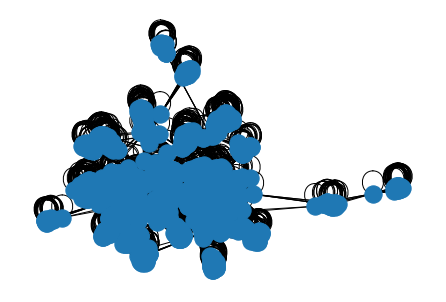

In [23]:
draw(g)

In [24]:
TSAJ.evaluate(g, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Top-K Schema Agnostic Join
***************************************************************************************************************************
Method name: Top-K Schema Agnostic Join
Parameters: 
	similarity_threshold: 0.25547445255474455
	K: 20
	metric: jaccard
	tokenization: qgrams
	qgrams: 3
Runtime: 39.3262 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     58.34% 
	Recall:        63.75%
	F1-score:      60.92%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 10954
	False positives: 7822
	True negatives: 823813
	False negatives: 6230
	Total comparisons: 18776
────────────────────────

### Entity Clustering

In [27]:
from pyjedai.clustering import ConnectedComponentsClustering

In [29]:
CCC = ConnectedComponentsClustering()
clusters = CCC.process(g, data)

In [30]:
CCC.evaluate(clusters)

***************************************************************************************************************************
                                         Μethod:  Connected Components Clustering
***************************************************************************************************************************
Method name: Connected Components Clustering
Parameters: 
Runtime: 0.0030 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      2.05% 
	Recall:       100.00%
	F1-score:       4.02%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
